## Imports
There are just a few imports for this analysis, but this version will deviate from the Soccermatics approach due to the mplsoccer library throwing and error when making a call to Statsbomb.  Instead, the statsbomb data will be called directly for the dataframe.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mplsoccer import Pitch, Sbopen, VerticalPitch
from statsbombpy import sb

## Opening and creating the dataset
Using the sb parser in place of SBopen in mplsoccer the event data is pulled out. Calling on the event level data and inputting the id of the game as a parameter loads the game data. The event data is stored in a dataframe df. From this dataframe, filter so that only passes not including throw ins are left in the frame.

In [2]:
# get event data
game_event = sb.events(match_id=69301)

In [3]:
game_event.head(2)

,bad_behaviour_card,ball_receipt_outcome,ball_recovery_recovery_failure,block_deflection,block_save_block,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,clearance_left_foot,...,shot_technique,shot_type,substitution_outcome,substitution_replacement,tactics,team,team_id,timestamp,type,under_pressure
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,"{'formation': 4141, 'lineup': [{'player': {'id...",England Women's,865,00:00:00.000,Starting XI,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,"{'formation': 4231, 'lineup': [{'player': {'id...",Sweden Women's,858,00:00:00.000,Starting XI,NaN


In [4]:
passes = (game_event
 .loc[lambda df: df.type == 'Pass', :]
#  .loc[lambda df: df.pass_type != 'Throw-in', :]
 .set_index('id')
 .assign(x = lambda df: df.location.apply(pd.Series)[0],
         y = lambda df: df.location.apply(pd.Series)[1],
         x_f = lambda df: df.pass_end_location.apply(pd.Series)[0],
         y_f = lambda df: df.pass_end_location.apply(pd.Series)[1])
         )

## Making a pass map
Filter out passes made by Lucy Bronze. Then, take only the columns needed to plot passes - coordinates of start and end of a pass. Draw a pitch using the arrows method plots the passes while using the scatter method will draw circles where the pass started filter. The dataset should only included completed passes for Lucy Bronze.

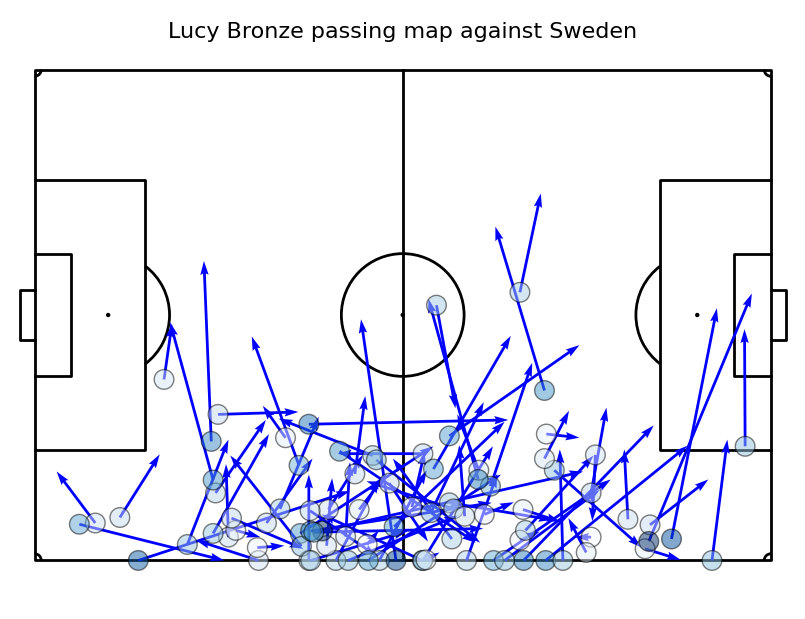

In [5]:
# Create the pitch
pitch = Pitch(line_color='black', goal_type='box', corner_arcs=True)
fig, ax = pitch.grid(figheight=6,grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

# filter for Lucy Bronze
lucy = (passes.query('player=="Lucy Bronze"')
#         .query('pass_type=="Throw-in"')
       )

# drawing on the pitch
pitch.arrows(lucy.x,lucy.y,lucy.x_f,lucy.y_f, ax=ax['pitch'], color='b', width=2)
pitch.scatter(lucy.x, lucy.y, ax=ax['pitch'], c=lucy.pass_length, s=200, cmap='Blues', alpha=0.5, edgecolor='k')

plt.suptitle('Lucy Bronze passing map against Sweden', fontsize=16)
plt.show()

## Plotting multiple pass maps on one figure
MPLsoccer allows multiple plots on one figure. To demonstrate, the passes made by all of England’s players will be plotted on seperate maps. 
1. First filter for players from England. 
2. Then, plot 16 pitches in 4 rows and columns for each player who was on the field during the game. 
3. Then each player's pass map will be plotted on a separate axis. 
4. As the last step remove unnecessary/unused pitches (during 2019 World Cup only 3, not 5, changes were allowed) and set the title.

Some notes the author doesn't highlight. 
- To associate a player with a pitch you must zip them together before plotting
- To conduct the zip, the axs created as a 4x4 must be flattended to a 1x16 using the flat method
- Walking backwards through the pitches, unneeded pitches are removed using ax.remove() and a list index.

In [6]:
#prepare the dataframe of passes by England that were no-throw ins
england_pass = (passes
                .query('team.str.startswith("England")')
                .query('pass_type!= "Throw-in"')
#                 .query('pass_length>=20')
               )
#get the list of all players who made a pass
names = england_pass.player.unique()
names

array(['Ellen White', 'Francesca Kirby', 'Lucy Bronze', 'Nikita Parris',
       'Jill Scott', 'Jade Moore', 'Bethany Mead', 'Alex Greenwood',
       'Carly Mitchell Telford', 'Abbie McManus', 'Stephanie Houghton',
       'Jodie Taylor', 'Karen Julia Carney', 'Rachel Daly'], dtype=object)

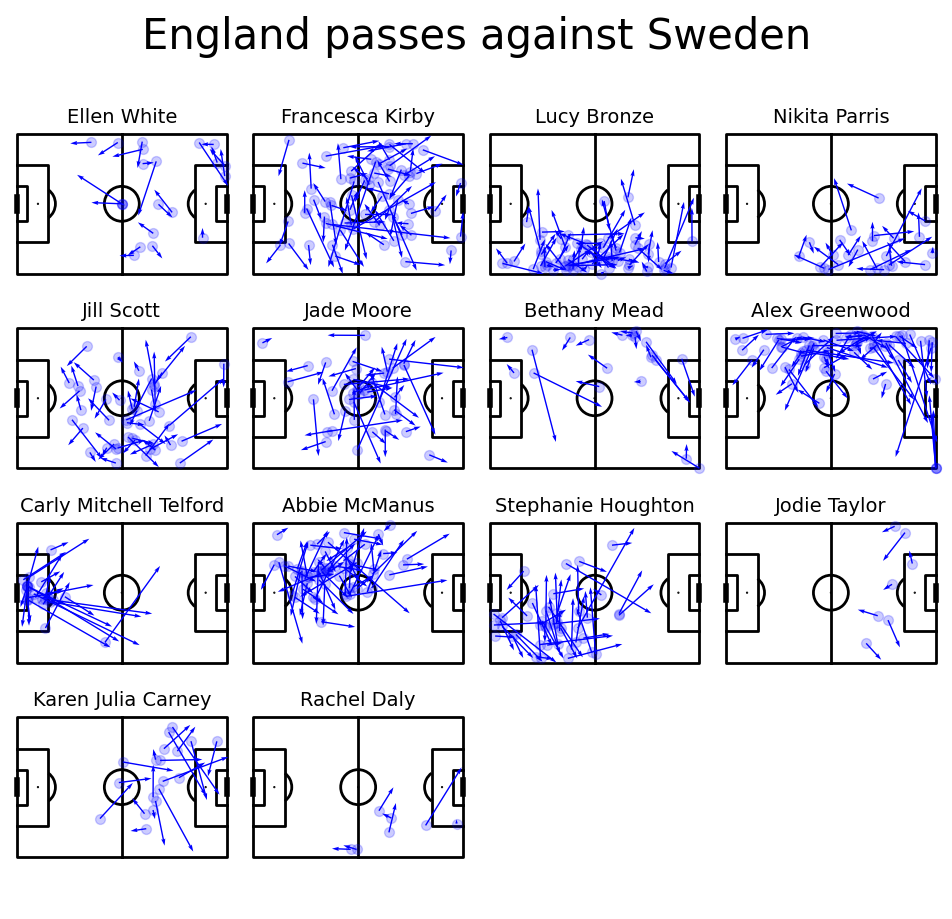

In [7]:
# draw 4x4 pitches
pitch = Pitch(line_color='black', pad_top=20)
fig, axs = pitch.grid(ncols = 4, nrows = 4, grid_height=0.85, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0.04, endnote_space=0.01)

#for each player, zip name and created pitch together in tuple before plotting.  ax.flat turns 4x4 into 1x16
for name, ax in zip(names, axs['pitch'].flat[:len(names)]):
    #put player name over the plot
    ax.text(60, -10, name,
            ha='center', va='center', fontsize=14)
    #take only passes by this player
    player_df = england_pass.loc[lambda df: df["player"] == name]
    #scatter
    pitch.scatter(player_df.x, player_df.y, alpha = 0.2, s = 50, color = "blue", ax=ax)
    #plot arrow
    pitch.arrows(player_df.x, player_df.y,
            player_df.x_f, player_df.y_f, color = "blue", ax=ax, width=1)

#We have more than enough pitches - remove them starting from end
for ax in axs['pitch'][-1, 16 - len(names):]:
    ax.remove()

#Another way to set title using mplsoccer
axs['title'].text(0.5, 0.5, 'England passes against Sweden', ha='center', va='center', fontsize=30)
plt.show()